## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [2]:
df = pd.read_csv("data/food_crises_month_imputed.csv") # Read data into DataFrame
df.set_index(["datetime", "district"], inplace=True) # Set index

<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [3]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [4]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [5]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'date', 'province', 'administrative_region', 'quarters',
       'count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [6]:
df.reset_index(inplace=True)
df.set_index('datetime', inplace=True)
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
# df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,date,province,administrative_region,quarters,count_violence_lag_3,ndvi_anom_lag_3,food_price_idx_lag_3,ipc_lag_1,ipc_lag_2,ipc_lag_3
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Terekeka,South Sudan,97,31.32576,5.662623,2009_07,2009,7,1.0,NaN,...,2009-07-01,Equatoria,Equatoria,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Duk,South Sudan,116,31.18647,7.617574,2009_07,2009,7,2.0,NaN,...,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Tonj East,South Sudan,117,29.28494,7.847276,2009_07,2009,7,1.0,NaN,...,2009-07-01,Bahr El Ghazal,Bahr El Ghazal,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Fashoda,South Sudan,147,31.84424,9.980295,2009_07,2009,7,1.0,NaN,...,2009-07-01,Greater Upper Nile,Greater Upper Nile,2009Q3,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Koch,South Sudan,127,29.85742,8.633903,2020_02,2020,2,3.0,0.0,...,2020-02-01,Greater Upper Nile,Greater Upper Nile,2020Q1,0.166667,111.294617,2.234340,3.0,3.0,3.0
2020-02-01,Aweil Center,South Sudan,128,26.89562,8.417934,2020_02,2020,2,3.0,1.0,...,2020-02-01,Bahr El Ghazal,Bahr El Ghazal,2020Q1,0.000000,105.971917,3.064545,3.0,3.0,3.0
2020-02-01,Gogrial East,South Sudan,129,28.58906,8.597443,2020_02,2020,2,3.0,0.0,...,2020-02-01,Bahr El Ghazal,Bahr El Ghazal,2020Q1,0.166667,106.954817,2.734335,3.0,2.0,2.0


## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [7]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["datetime"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [8]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["datetime"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

In [9]:
news_df

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict,corruption,terrorism,nature,oil,datetime
0,The article discusses the passing of the new C...,2011-07-07,Juba,4.859363,31.571250,False,False,False,False,False,False,False,False,2011-07-01
1,The article discusses the military actions tak...,2011-07-03,Abyei,9.838551,28.486396,False,False,False,False,False,False,False,False,2011-07-01
2,The article discusses the signing of a Framewo...,2011-06-30,Southern Kordofan,11.036544,30.895824,False,False,False,False,False,False,False,False,2011-06-01
3,The article discusses the upcoming independenc...,2011-07-04,South Sudan,6.876992,31.306979,False,False,False,False,False,False,False,False,2011-07-01
4,The article discusses the need for South Sudan...,2011-07-02,Juba,4.859363,31.571250,False,False,False,False,False,False,False,False,2011-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-26,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False,False,False,False,False,2023-04-01
18516,The article discusses the bombing and forced e...,2023-04-26,Khartoum,15.500654,32.559899,False,False,False,False,False,False,False,False,2023-04-01
18517,The article discusses how Prime Minister Abiy ...,2023-04-23,Addis Ababa,8.980603,38.757761,False,False,False,False,False,False,False,False,2023-04-01
18518,The article discusses the collapse of a commer...,2023-04-17,Kampala International University,0.294360,32.603970,False,False,False,True,False,False,False,False,2023-04-01


In [10]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian', 'corruption', 'terrorism', 'nature', 'oil'])
news_features.dropna(how='all', inplace=True)
news_features

,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil
datetime,,,,,,,,
2011-11-01,0.028705,0.003101,1.978309e-02,0.004841,0.037745,0.013654,2.628419e-02,0.018686
2011-12-01,0.021502,0.003101,8.835235e-03,0.006714,0.032703,0.013654,2.095432e-02,0.018686
2012-01-01,0.033894,0.003101,1.069100e-02,0.004973,0.035406,0.012830,3.245270e-02,0.016144
2012-02-01,0.027422,0.002372,2.611212e-02,0.004245,0.041889,0.020135,2.634494e-02,0.015967
2012-03-01,0.028441,0.005322,2.571438e-02,0.005322,0.029402,0.030459,2.991625e-02,0.024817
...,...,...,...,...,...,...,...,...
2022-12-01,0.047863,0.027778,9.251859e-18,0.044444,0.000000,0.022222,5.551115e-17,0.000000
2023-01-01,0.022222,0.027778,9.251859e-18,0.044444,0.027778,0.022222,5.555556e-02,0.000000
2023-02-01,0.083333,0.027778,9.251859e-18,0.000000,0.027778,0.000000,1.388889e-01,0.000000


In [11]:
df.index = pd.to_datetime(df.index)
news_features.index = pd.to_datetime(news_features.index)

## Predicting using news features

In [12]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
# df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.merge(news_features, left_index=True, right_index=True, how='left')
df.drop(['province'], axis=1, inplace=True)
df

,district,country,district_code,centx,centy,year_month,year,month,ipc,ha,...,ipc_lag_2,ipc_lag_3,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil
datetime,,,,,,,,,,,,,,,,,,,,,
2009-07-01,Bor,South Sudan,74,32.00486,6.465644,2009_07,2009,7,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Mundri East,South Sudan,92,30.68256,5.307882,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Nyirol,South Sudan,130,32.11970,8.583063,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Aweil East,South Sudan,141,27.61364,9.243139,2009_07,2009,7,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,Yei,South Sudan,81,30.34454,4.252148,2009_07,2009,7,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,Jur River,South Sudan,75,28.02439,7.592506,2020_02,2020,2,2.0,0.0,...,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144
2020-02-01,Bor,South Sudan,74,32.00486,6.465644,2020_02,2020,2,3.0,0.0,...,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144
2020-02-01,Juba,South Sudan,90,31.48342,4.717081,2020_02,2020,2,3.0,0.0,...,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144


In [13]:
d= df.copy()
d.drop(['quarters', 'ha'], axis=1, inplace=True)
# df.drop(['ipc', 'country', 'district_code', 'year', 'year_month', 'month', 'quarters', 'date'], axis=1)
d = d.iloc[:, -14:] # Define explanatory variables
d

,count_violence_lag_3,ndvi_anom_lag_3,food_price_idx_lag_3,ipc_lag_1,ipc_lag_2,ipc_lag_3,hunger,refugees,conflict,humanitarian,corruption,terrorism,nature,oil
datetime,,,,,,,,,,,,,,
2009-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,0.666667,103.881867,2.033972,2.0,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144
2020-02-01,0.833333,109.419183,2.836840,3.0,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144
2020-02-01,4.333333,106.478217,3.584992,3.0,3.0,3.0,0.011494,0.0,9.251859e-18,0.010753,0.090471,0.0,0.027897,0.050144


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from  sklearn.ensemble import RandomForestClassifier

# Assuming df is your DataFrame containing the data
encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')  # You can adjust the imputation strategy as needed

X = df.drop(['ipc', 'country', 'district_code', 'year', 'year_month', 'month', 'quarters', 'date',  'centx', 'centy'], axis=1) # Define explanatory variables
print(X.columns)
X = sm.add_constant(X)  # Add constant column of 1s for intercept
y = df[["ipc"]]  # Define target data

# Assuming ipc is a categorical variable with values 1 to 5, convert it to integers
y = y.astype(int)

# Use StratifiedKFold for stratified splitting
cv = StratifiedKFold(n_splits=5)

# Initialize empty lists to store scores.6f}"
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Interpolate training and testing data
    X_train = X_train.interpolate()
    X_test = X_test.interpolate()
    y_train = y_train.interpolate()

    # Encode categorical features
    X_train['administrative_region'] = encoder.fit_transform(X_train['administrative_region'])
    X_test['administrative_region'] = encoder.transform(X_test['administrative_region'])
    X_train['district'] = encoder.fit_transform(X_train['district'])
    X_test['district'] = encoder.transform(X_test['district'])

    # Impute missing values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train the RandomForestRegressor
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train, y=np.ravel(y_train))

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))

print(f"Mean MSE: {np.mean(mse_values):.6f}")
print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

KeyError: "['province'] not found in axis"

Index(['district', 'centx', 'centy', 'ha', 'ndvi_mean', 'ndvi_anom',
       'rain_mean', 'rain_anom', 'et_mean', 'et_anom', 'count_violence',
       'sum_fatalities', 'food_price_idx', 'area', 'cropland_pct', 'pop',
       'ruggedness_mean', 'pasture_pct', 'administrative_region',
       'count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger', 'refugees', 'conflict',
       'humanitarian', 'corruption', 'terrorism', 'nature', 'oil'],
      dtype='object')


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/tmp/ipykernel_16192/477837364.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['administrative_region'] = encoder.fit_transform(X_train['administrative_region'])
/tmp/ipykernel_16192/477837364.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['administrative_reg

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=3,
                       n_estimators=25)


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


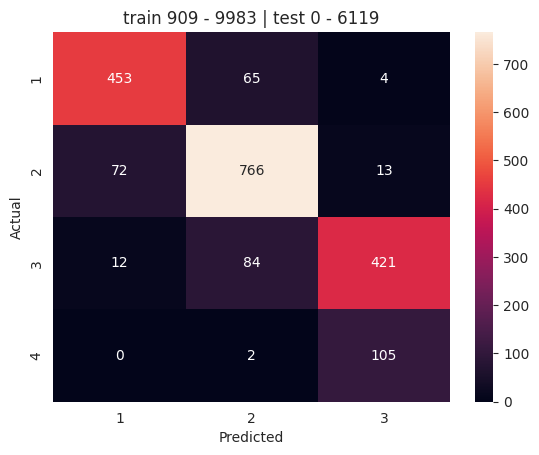

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.84      0.87      0.86       522
           2       0.84      0.90      0.87       851
           3       0.78      0.81      0.79       517
           4       0.00      0.00      0.00       107

    accuracy                           0.82      1997
   macro avg       0.61      0.65      0.63      1997
weighted avg       0.78      0.82      0.80      1997


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152:

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=3,
                       n_estimators=25)


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


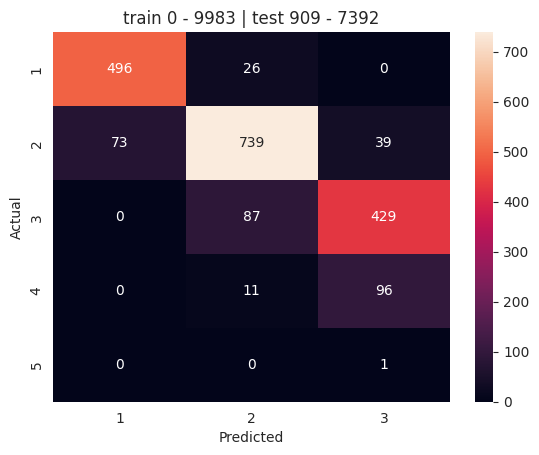

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.87      0.95      0.91       522
           2       0.86      0.87      0.86       851
           3       0.76      0.83      0.79       516
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00         1

    accuracy                           0.83      1997
   macro avg       0.50      0.53      0.51      1997
weighted avg       0.79      0.83      0.81      1997


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152:

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=3,
                       n_estimators=25)


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


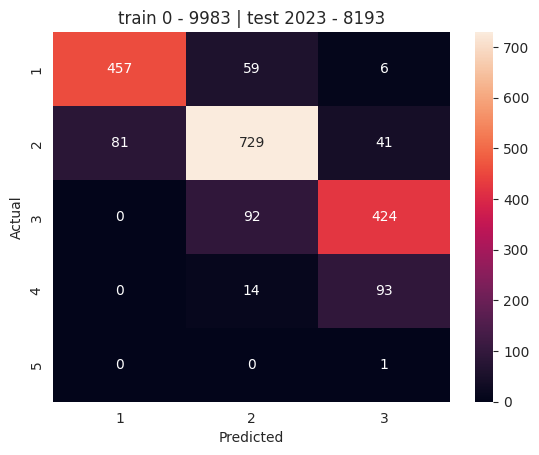

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.85      0.88      0.86       522
           2       0.82      0.86      0.84       851
           3       0.75      0.82      0.78       516
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00         1

    accuracy                           0.81      1997
   macro avg       0.48      0.51      0.50      1997
weighted avg       0.76      0.81      0.78      1997


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152:

RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=3,
                       n_estimators=25)


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


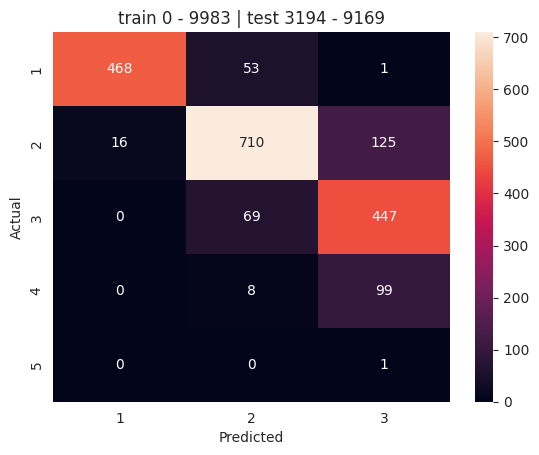

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.97      0.90      0.93       522
           2       0.85      0.83      0.84       851
           3       0.66      0.87      0.75       516
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00         1

    accuracy                           0.81      1997
   macro avg       0.50      0.52      0.50      1997
weighted avg       0.78      0.81      0.80      1997


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152:

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                       n_estimators=25)


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


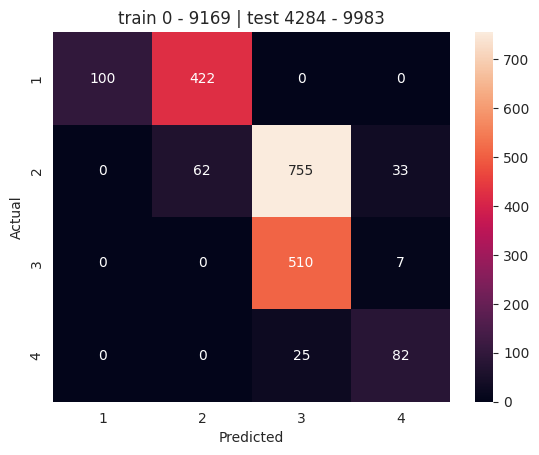

              precision    recall  f1-score   support

           1       1.00      0.19      0.32       522
           2       0.13      0.07      0.09       850
           3       0.40      0.99      0.56       517
           4       0.67      0.77      0.72       107

    accuracy                           0.38      1996
   macro avg       0.55      0.50      0.42      1996
weighted avg       0.45      0.38      0.31      1996

Mean MSE: 0.297814
Mean R-squared: 0.589428
Mean Accuracy: 0.730433
Accuracy of each set: [0.8212318477716575, 0.8332498748122183, 0.8062093139709564, 0.8137205808713069, 0.3777555110220441]


<Figure size 640x480 with 0 Axes>

In [32]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from  sklearn.ensemble import RandomForestClassifier


param_grid = {
	'n_estimators': [25, 50, 100, 150],
	'max_features': ['sqrt', 'log2', None],
	'max_depth': [3, 6, 9],
	'max_leaf_nodes': [3, 6, 9],
}


# Assuming df is your DataFrame containing the data
encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')  # You can adjust the imputation strategy as needed

X = df.drop(['ipc', 'country', 'district_code', 'year', 'year_month', 'month', 'quarters', 'date'], axis=1) # Define explanatory variables
print(X.columns)
X = sm.add_constant(X)  # Add constant column of 1s for intercept
y = df[["ipc"]]  # Define target data

# Assuming ipc is a categorical variable with values 1 to 5, convert it to integers
y = y.astype(int)

# Use StratifiedKFold for stratified splitting
cv = StratifiedKFold(n_splits=5)

# Initialize empty lists to store scores.6f}"
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Interpolate training and testing data
    # X_train = X_train.interpolate()
    # X_test = X_test.interpolate()
    # y_train = y_train.interpolate()

    # Encode categorical features
    X_train['administrative_region'] = encoder.fit_transform(X_train['administrative_region'])
    X_test['administrative_region'] = encoder.transform(X_test['administrative_region'])
    X_train['district'] = encoder.fit_transform(X_train['district'])
    X_test['district'] = encoder.transform(X_test['district'])

    # Impute missing values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train the classifier
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_estimator_)
    best_estimates = grid_search.best_estimator_
    
    rf_classifier = best_estimates
    rf_classifier.fit(X_train, y_train)
    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))

print(f"Mean MSE: {np.mean(mse_values):.6f}")
print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

Index(['count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


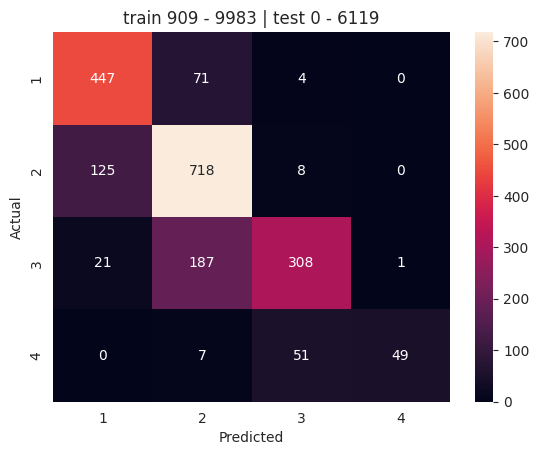

              precision    recall  f1-score   support

           1       0.75      0.86      0.80       522
           2       0.73      0.84      0.78       851
           3       0.83      0.60      0.69       517
           4       0.98      0.46      0.62       107

    accuracy                           0.76      1997
   macro avg       0.82      0.69      0.73      1997
weighted avg       0.78      0.76      0.76      1997


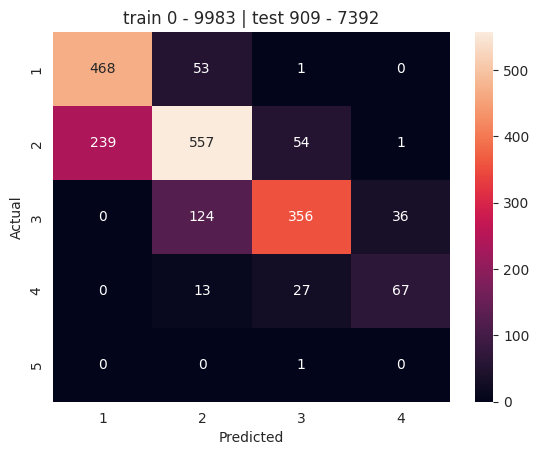

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.66      0.90      0.76       522
           2       0.75      0.65      0.70       851
           3       0.81      0.69      0.75       516
           4       0.64      0.63      0.64       107
           5       0.00      0.00      0.00         1

    accuracy                           0.73      1997
   macro avg       0.57      0.57      0.57      1997
weighted avg       0.73      0.73      0.72      1997


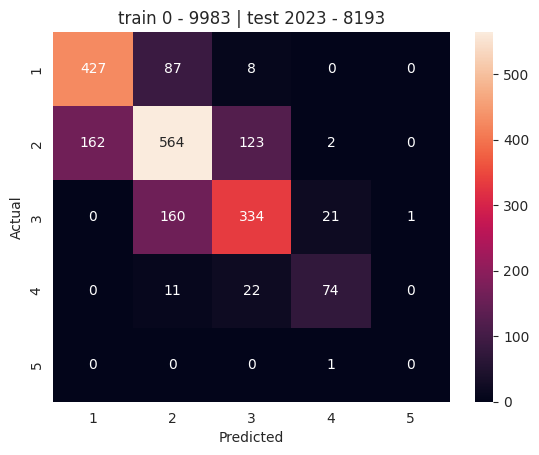

              precision    recall  f1-score   support

           1       0.72      0.82      0.77       522
           2       0.69      0.66      0.67       851
           3       0.69      0.65      0.67       516
           4       0.76      0.69      0.72       107
           5       0.00      0.00      0.00         1

    accuracy                           0.70      1997
   macro avg       0.57      0.56      0.57      1997
weighted avg       0.70      0.70      0.70      1997


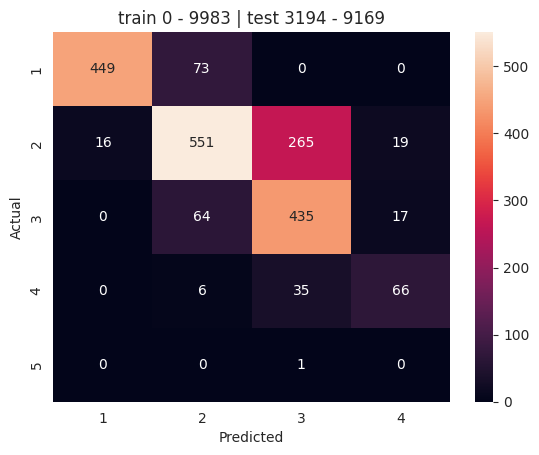

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.97      0.86      0.91       522
           2       0.79      0.65      0.71       851
           3       0.59      0.84      0.69       516
           4       0.65      0.62      0.63       107
           5       0.00      0.00      0.00         1

    accuracy                           0.75      1997
   macro avg       0.60      0.59      0.59      1997
weighted avg       0.78      0.75      0.76      1997


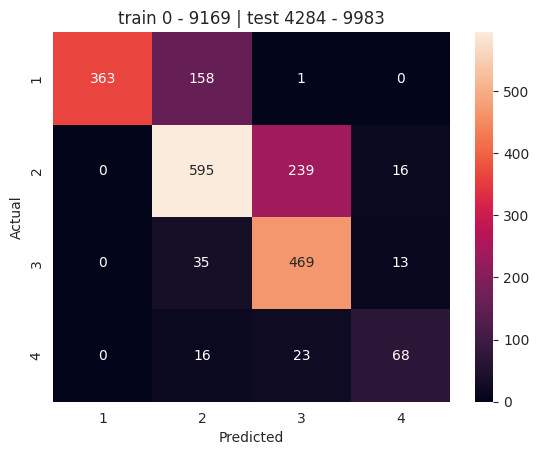

              precision    recall  f1-score   support

           1       1.00      0.70      0.82       522
           2       0.74      0.70      0.72       850
           3       0.64      0.91      0.75       517
           4       0.70      0.64      0.67       107

    accuracy                           0.75      1996
   macro avg       0.77      0.73      0.74      1996
weighted avg       0.78      0.75      0.75      1996

Mean MSE: 0.301082
Mean R-squared: 0.585305
Mean Accuracy: 0.737681
Accuracy of each set: [0.7621432148222334, 0.7250876314471708, 0.700550826239359, 0.7516274411617426, 0.748997995991984]


<Figure size 640x480 with 0 Axes>

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from  sklearn.ensemble import RandomForestClassifier

# Assuming df is your DataFrame containing the data
encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')  # You can adjust the imputation strategy as needed

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
# df.drop(['ipc', 'country', 'district_code', 'year', 'year_month', 'month', 'quarters', 'date'], axis=1)
X = df_copy.iloc[:, 26:32] # Define explanatory variables
print(X.columns)
X = sm.add_constant(X)  # Add constant column of 1s for intercept
y = df_copy[["ipc"]]  # Define target data

# Assuming ipc is a categorical variable with values 1 to 5, convert it to integers
y = y.astype(int)

# Use StratifiedKFold for stratified splitting
cv = StratifiedKFold(n_splits=5)

# Initialize empty lists to store scores.6f}"
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Interpolate training and testing data
    X_train = X_train.interpolate()
    X_test = X_test.interpolate()
    y_train = y_train.interpolate()

    # Encode categorical features
    # X_train['administrative_region'] = encoder.fit_transform(X_train['administrative_region'])
    # X_test['administrative_region'] = encoder.transform(X_test['administrative_region'])

    # Impute missing values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train the RandomForestRegressor
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train, y=np.ravel(y_train))

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))

print(f"Mean MSE: {np.mean(mse_values):.6f}")
print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

Index(['count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger', 'refugees', 'conflict',
       'humanitarian', 'corruption', 'terrorism', 'nature', 'oil'],
      dtype='object')


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


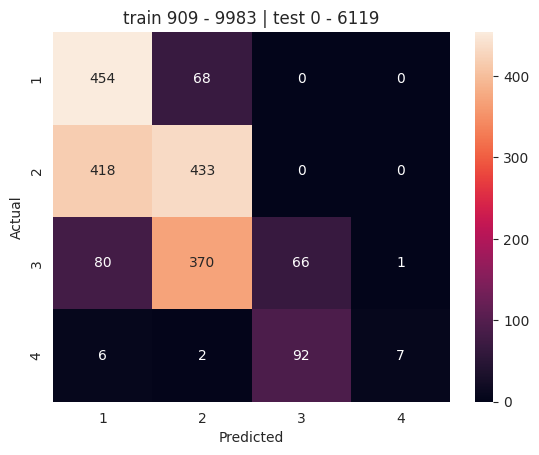

              precision    recall  f1-score   support

           1       0.47      0.87      0.61       522
           2       0.50      0.51      0.50       851
           3       0.42      0.13      0.20       517
           4       0.88      0.07      0.12       107

    accuracy                           0.48      1997
   macro avg       0.57      0.39      0.36      1997
weighted avg       0.49      0.48      0.43      1997


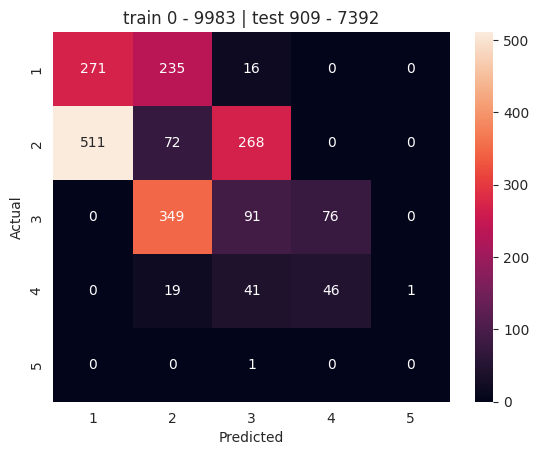

              precision    recall  f1-score   support

           1       0.35      0.52      0.42       522
           2       0.11      0.08      0.09       851
           3       0.22      0.18      0.20       516
           4       0.38      0.43      0.40       107
           5       0.00      0.00      0.00         1

    accuracy                           0.24      1997
   macro avg       0.21      0.24      0.22      1997
weighted avg       0.21      0.24      0.22      1997


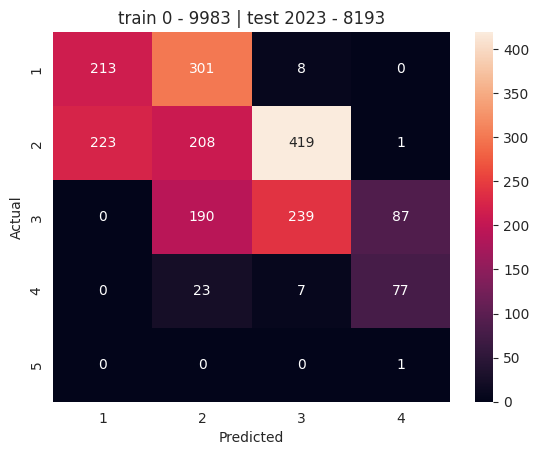

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.49      0.41      0.44       522
           2       0.29      0.24      0.26       851
           3       0.36      0.46      0.40       516
           4       0.46      0.72      0.56       107
           5       0.00      0.00      0.00         1

    accuracy                           0.37      1997
   macro avg       0.32      0.37      0.34      1997
weighted avg       0.37      0.37      0.36      1997


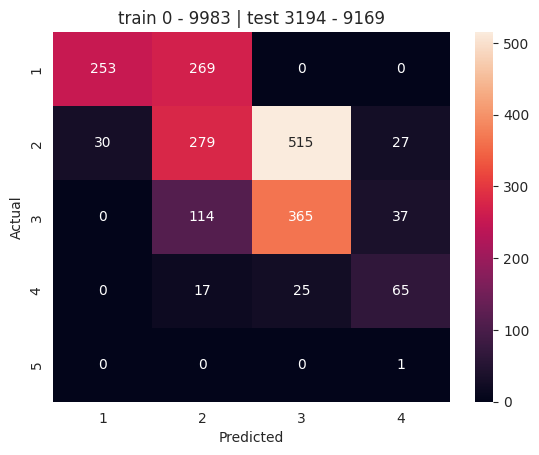

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.89      0.48      0.63       522
           2       0.41      0.33      0.36       851
           3       0.40      0.71      0.51       516
           4       0.50      0.61      0.55       107
           5       0.00      0.00      0.00         1

    accuracy                           0.48      1997
   macro avg       0.44      0.43      0.41      1997
weighted avg       0.54      0.48      0.48      1997


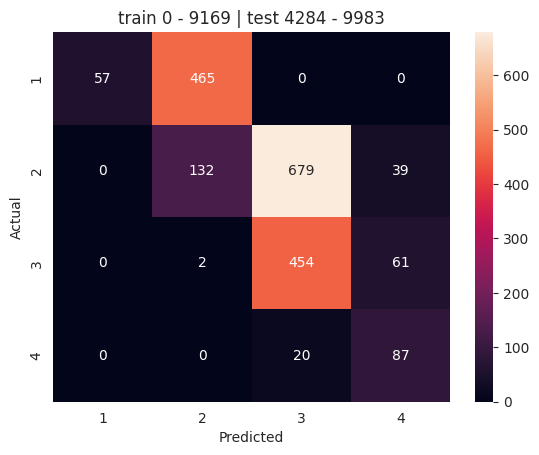

              precision    recall  f1-score   support

           1       1.00      0.11      0.20       522
           2       0.22      0.16      0.18       850
           3       0.39      0.88      0.54       517
           4       0.47      0.81      0.59       107

    accuracy                           0.37      1996
   macro avg       0.52      0.49      0.38      1996
weighted avg       0.48      0.37      0.30      1996

Mean MSE: 0.687300
Mean R-squared: 0.053319
Mean Accuracy: 0.387518
Accuracy of each set: [0.48072108162243365, 0.24036054081121683, 0.36905358037055586, 0.48172258387581374, 0.3657314629258517]


<Figure size 640x480 with 0 Axes>

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from  sklearn.ensemble import RandomForestClassifier

# Assuming df is your DataFrame containing the data
encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')  # You can adjust the imputation strategy as needed

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
# df.drop(['ipc', 'country', 'district_code', 'year', 'year_month', 'month', 'quarters', 'date'], axis=1)
X = df_copy.iloc[:, -14:] # Define explanatory variables
print(X.columns)
X = sm.add_constant(X)  # Add constant column of 1s for intercept
y = df_copy[["ipc"]]  # Define target data

# Assuming ipc is a categorical variable with values 1 to 5, convert it to integers
y = y.astype(int)

# Use StratifiedKFold for stratified splitting
cv = StratifiedKFold(n_splits=5)

# Initialize empty lists to store scores.6f}"
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Interpolate training and testing data
    # X_train = X_train.interpolate()
    # X_test = X_test.interpolate()
    # y_train = y_train.interpolate()

    # Encode categorical features
    # X_train['administrative_region'] = encoder.fit_transform(X_train['administrative_region'])
    # X_test['administrative_region'] = encoder.transform(X_test['administrative_region'])

    # Impute missing values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train the RandomForestRegressor
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train, y=np.ravel(y_train))

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))

print(f"Mean MSE: {np.mean(mse_values):.6f}")
print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

Index(['count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger', 'refugees', 'conflict',
       'humanitarian', 'corruption', 'terrorism', 'nature', 'oil'],
      dtype='object')


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


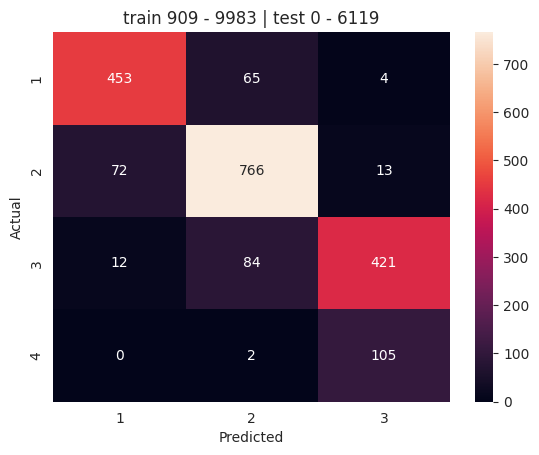

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.84      0.87      0.86       522
           2       0.84      0.90      0.87       851
           3       0.78      0.81      0.79       517
           4       0.00      0.00      0.00       107

    accuracy                           0.82      1997
   macro avg       0.61      0.65      0.63      1997
weighted avg       0.78      0.82      0.80      1997


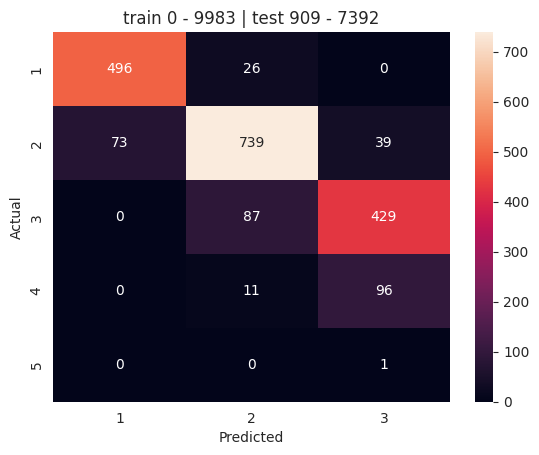

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.87      0.95      0.91       522
           2       0.86      0.87      0.86       851
           3       0.76      0.83      0.79       516
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00         1

    accuracy                           0.83      1997
   macro avg       0.50      0.53      0.51      1997
weighted avg       0.79      0.83      0.81      1997


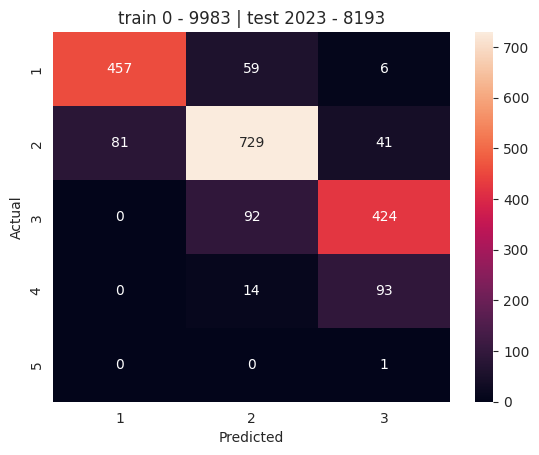

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.85      0.88      0.86       522
           2       0.82      0.86      0.84       851
           3       0.75      0.82      0.78       516
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00         1

    accuracy                           0.81      1997
   macro avg       0.48      0.51      0.50      1997
weighted avg       0.76      0.81      0.78      1997


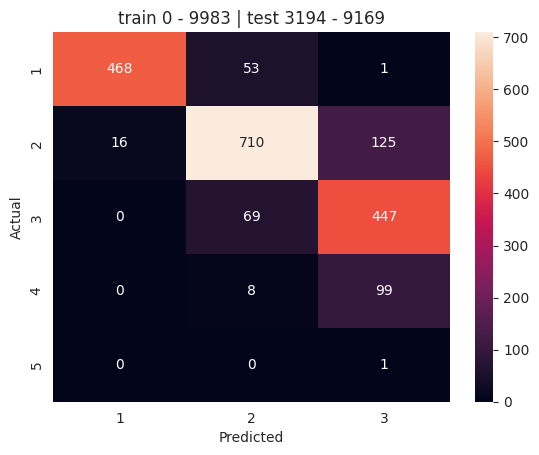

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.97      0.90      0.93       522
           2       0.85      0.83      0.84       851
           3       0.66      0.87      0.75       516
           4       0.00      0.00      0.00       107
           5       0.00      0.00      0.00         1

    accuracy                           0.81      1997
   macro avg       0.50      0.52      0.50      1997
weighted avg       0.78      0.81      0.80      1997


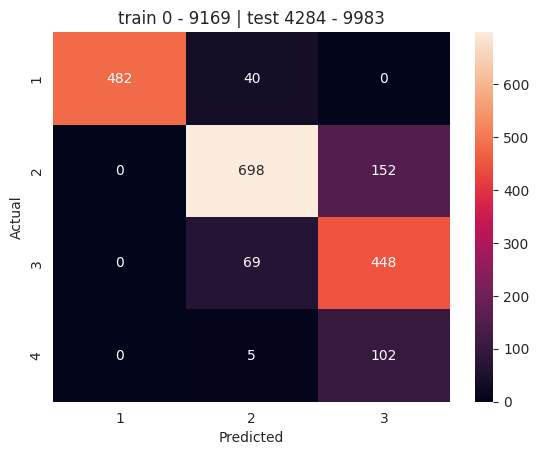

              precision    recall  f1-score   support

           1       1.00      0.92      0.96       522
           2       0.86      0.82      0.84       850
           3       0.64      0.87      0.74       517
           4       0.00      0.00      0.00       107

    accuracy                           0.82      1996
   macro avg       0.62      0.65      0.63      1996
weighted avg       0.79      0.82      0.80      1996

Mean MSE: 0.201822
Mean R-squared: 0.722013
Mean Accuracy: 0.818009
Accuracy of each set: [0.8212318477716575, 0.8332498748122183, 0.8062093139709564, 0.8137205808713069, 0.8156312625250501]


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from  sklearn.ensemble import RandomForestClassifier

# Assuming df is your DataFrame containing the data
encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')  # You can adjust the imputation strategy as needed

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
# df.drop(['ipc', 'country', 'district_code', 'year', 'year_month', 'month', 'quarters', 'date'], axis=1)
X = df_copy.iloc[:, -14:] # Define explanatory variables
print(X.columns)
X = sm.add_constant(X)  # Add constant column of 1s for intercept
y = df_copy[["ipc"]]  # Define target data

# Assuming ipc is a categorical variable with values 1 to 5, convert it to integers
y = y.astype(int)
y = y.astype(int)

# Use StratifiedKFold for stratified splitting
cv = StratifiedKFold(n_splits=5)

# Initialize empty lists to store scores.6f}"
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Interpolate training and testing data
    # X_train = X_train.interpolate()
    # X_test = X_test.interpolate()
    # y_train = y_train.interpolate()

    # Encode categorical features
    # X_train['administrative_region'] = encoder.fit_transform(X_train['administrative_region'])
    # X_test['administrative_region'] = encoder.transform(X_test['administrative_region'])

    # Impute missing values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train the RandomForestRegressor
    rf_classifier = RandomForestClassifier(max_depth=3, max_features=None, max_leaf_nodes=3,
                       n_estimators=25)
    results = rf_classifier.fit(X=X_train, y=np.ravel(y_train))

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))

print(f"Mean MSE: {np.mean(mse_values):.6f}")
print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

Index(['count_violence_lag_3', 'ndvi_anom_lag_3', 'food_price_idx_lag_3',
       'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3', 'hunger', 'refugees', 'conflict',
       'humanitarian', 'corruption', 'terrorism', 'nature', 'oil'],
      dtype='object')


/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


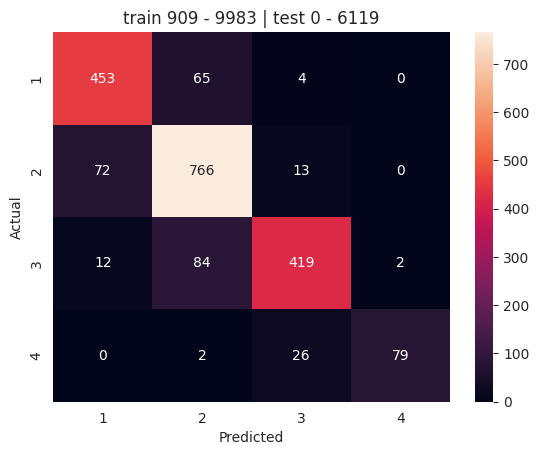

              precision    recall  f1-score   support

           1       0.84      0.87      0.86       522
           2       0.84      0.90      0.87       851
           3       0.91      0.81      0.86       517
           4       0.98      0.74      0.84       107

    accuracy                           0.86      1997
   macro avg       0.89      0.83      0.85      1997
weighted avg       0.86      0.86      0.86      1997


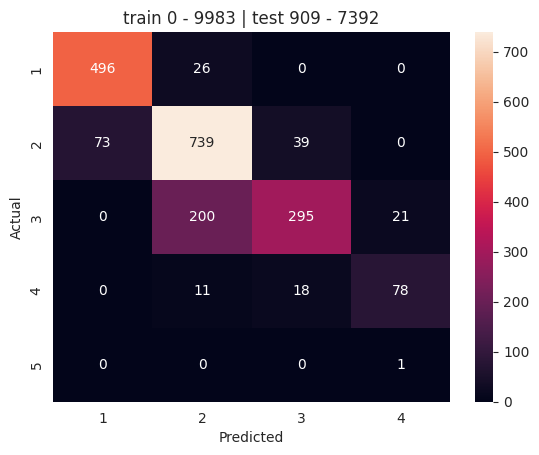

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.87      0.95      0.91       522
           2       0.76      0.87      0.81       851
           3       0.84      0.57      0.68       516
           4       0.78      0.73      0.75       107
           5       0.00      0.00      0.00         1

    accuracy                           0.81      1997
   macro avg       0.65      0.62      0.63      1997
weighted avg       0.81      0.81      0.80      1997


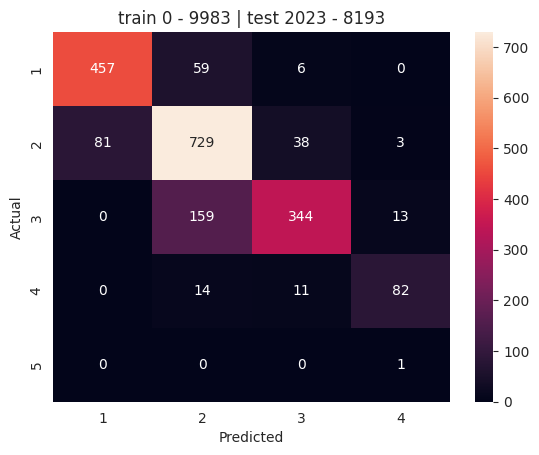

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.85      0.88      0.86       522
           2       0.76      0.86      0.80       851
           3       0.86      0.67      0.75       516
           4       0.83      0.77      0.80       107
           5       0.00      0.00      0.00         1

    accuracy                           0.81      1997
   macro avg       0.66      0.63      0.64      1997
weighted avg       0.81      0.81      0.81      1997


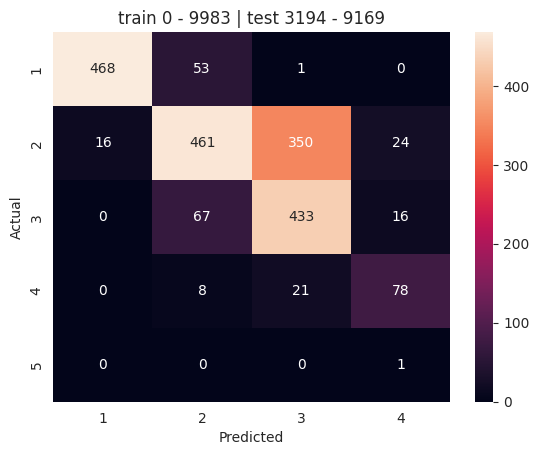

/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/julia/PycharmProjects/JBG060-group9/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

              precision    recall  f1-score   support

           1       0.97      0.90      0.93       522
           2       0.78      0.54      0.64       851
           3       0.54      0.84      0.66       516
           4       0.66      0.73      0.69       107
           5       0.00      0.00      0.00         1

    accuracy                           0.72      1997
   macro avg       0.59      0.60      0.58      1997
weighted avg       0.76      0.72      0.72      1997


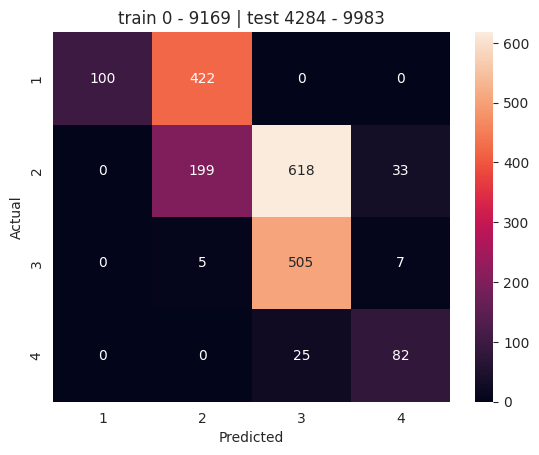

              precision    recall  f1-score   support

           1       1.00      0.19      0.32       522
           2       0.32      0.23      0.27       850
           3       0.44      0.98      0.61       517
           4       0.67      0.77      0.72       107

    accuracy                           0.44      1996
   macro avg       0.61      0.54      0.48      1996
weighted avg       0.55      0.44      0.39      1996

Mean MSE: 0.308023
Mean R-squared: 0.575537
Mean Accuracy: 0.727436
Accuracy of each set: [0.8597896845267902, 0.8052078117175764, 0.8072108162243365, 0.7210816224336505, 0.4438877755511022]


<Figure size 640x480 with 0 Axes>

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from  sklearn.ensemble import RandomForestClassifier

# Assuming df is your DataFrame containing the data
encoder = LabelEncoder()
imputer = SimpleImputer(strategy='mean')  # You can adjust the imputation strategy as needed

df_copy = df.copy()
df_copy.drop(['quarters', 'ha'], axis=1, inplace=True)
# df.drop(['ipc', 'country', 'district_code', 'year', 'year_month', 'month', 'quarters', 'date'], axis=1)
X = df_copy.iloc[:, -14:] # Define explanatory variables
print(X.columns)
X = sm.add_constant(X)  # Add constant column of 1s for intercept
y = df_copy[["ipc"]]  # Define target data

# Assuming ipc is a categorical variable with values 1 to 5, convert it to integers
y = y.astype(int)

# Use StratifiedKFold for stratified splitting
cv = StratifiedKFold(n_splits=5)

# Initialize empty lists to store scores.6f}"
mse_values = list()
r2_values = list()
accuracy_values = list()

for train_index, val_index in cv.split(X, y):  # Use X and y as inputs for splitting

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Interpolate training and testing data
    # X_train = X_train.interpolate()
    # X_test = X_test.interpolate()
    # y_train = y_train.interpolate()

    # Encode categorical features
    # X_train['administrative_region'] = encoder.fit_transform(X_train['administrative_region'])
    # X_test['administrative_region'] = encoder.transform(X_test['administrative_region'])

    # Impute missing values
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train the RandomForestRegressor
    rf_classifier = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=6,
                       n_estimators=25)
    results = rf_classifier.fit(X=X_train, y=np.ravel(y_train))

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_values.append(mse)
    r2_values.append(r2)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))

print(f"Mean MSE: {np.mean(mse_values):.6f}")
print(f"Mean R-squared: {np.mean(r2_values):.6f}")
print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(f"Accuracy of each set: {accuracy_values}")

Iteration: 0
Iteration: 1
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- humanitarian
- hunger
- refugees

  warnings.warn(message, FutureWarning)


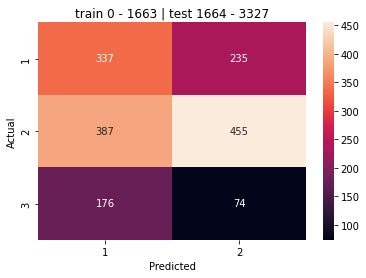

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.37      0.59      0.46       572
           2       0.60      0.54      0.57       842
           3       0.00      0.00      0.00       250

    accuracy                           0.48      1664
   macro avg       0.32      0.38      0.34      1664
weighted avg       0.43      0.48      0.44      1664

Iteration: 0
Iteration: 1
Iteration: 2
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


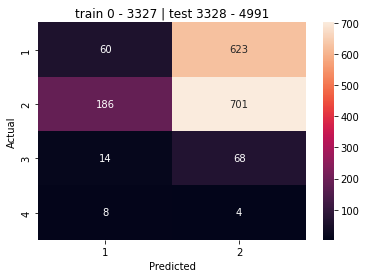

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.22      0.09      0.13       683
           2       0.50      0.79      0.61       887
           3       0.00      0.00      0.00        82
           4       0.00      0.00      0.00        12

    accuracy                           0.46      1664
   macro avg       0.18      0.22      0.19      1664
weighted avg       0.36      0.46      0.38      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


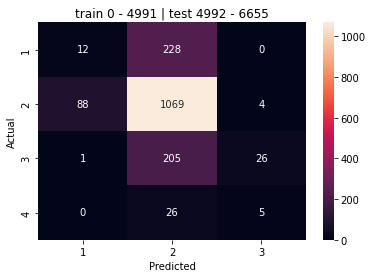

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.12      0.05      0.07       240
           2       0.70      0.92      0.80      1161
           3       0.74      0.11      0.19       232
           4       0.00      0.00      0.00        31

    accuracy                           0.67      1664
   macro avg       0.39      0.27      0.27      1664
weighted avg       0.61      0.67      0.59      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


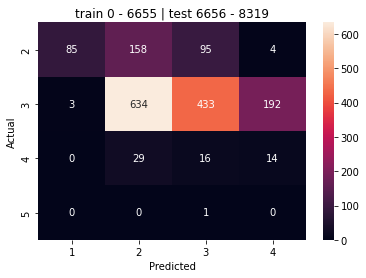

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.19      0.46      0.27       342
           3       0.79      0.34      0.48      1262
           4       0.07      0.24      0.10        59
           5       0.00      0.00      0.00         1

    accuracy                           0.36      1664
   macro avg       0.21      0.21      0.17      1664
weighted avg       0.64      0.36      0.42      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


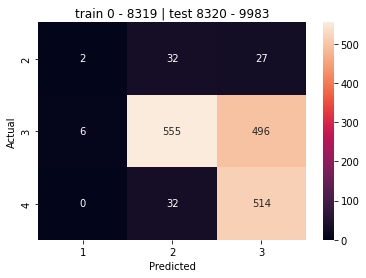

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.05      0.52      0.09        61
           3       0.48      0.47      0.47      1057
           4       0.00      0.00      0.00       546

    accuracy                           0.32      1664
   macro avg       0.13      0.25      0.14      1664
weighted avg       0.31      0.32      0.30      1664

Mean Accuracy: 0.455889
[0.47596153846153844, 0.4573317307692308, 0.6652644230769231, 0.3635817307692308, 0.3173076923076923]


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

<Figure size 432x288 with 0 Axes>

In [11]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings

# Specifying the warnings to be ignored
warnings.filterwarnings(
    action="ignore",
    message="Criterion 'mse'",
)
warnings.filterwarnings(
    action="ignore",
    message="`max_features='auto'`",
)

imputer = MissForest()
label_encoder = LabelEncoder()
df_copy = df.copy() # Make a copy of the original df
df_copy.ffill(inplace=True) # Data imputation using forward fill
df_copy['ipc'] = df_copy['ipc'].astype('int') # Convert the ipc values to integer

X = df_copy.iloc[:, 27:33] # Define explanatory variables
print(X.columns)
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df_copy[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    # X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # X_train.reset_index(level=0, drop=True, inplace=True)
    # y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    # y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    # print(np.count_nonzero(np.isnan(X_train_imputed)))
    # print(np.count_nonzero(np.isnan(X_test_imputed)))

    # Train the RandomForestClassifier
    # number of trees is 100, and  42 is just to initialize random number to make random choices during training
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train_imputed, y=np.ravel(y_train))

    rf_classifier.feature_names_in_ = list(X.columns)

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))


print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(accuracy_values)

# Why it predicts different values each time?
# In the early years of the data, only ipc 1 and 2 prevail with ipc 3 occurs the least. Thus in the first two iterations it only predicts
# 1 and 2. Then we see more ipc 3 for which it begins to predict in the 3rd iteration. The same can be said about ipc 4. In the final 
# iteration, it focuses on only predicting ipc 2 and 3 which the model thinks it predicts best.

    